## Exercise 1

In [1]:
# Import libraries
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
from tensorflow.contrib import learn
from tqdm import trange
from time import time
from Autoencoder.utils import *
from PIL import Image
import glob
from sklearn.model_selection import train_test_split

In [2]:
class AutoEncoder(object):
    def __init__(self,
               sess,
               inputs,
               targets=None,
               b1=0.5,
               lr=0.5,
               code_size=90,
               batch_size=16,
               n_epoch=200,
               cost_function='bce',
               name='autoencoder',
               optimizer='adadelta', w=128, h=128):
        self.sess = sess  #tensorflow session
        self.b1 = b1  #beta1 for AdadeltaOptimizer
        self.lr = lr  #learning rate
        self.n_epoch = n_epoch  #number of epoch
        self.batch_size = batch_size
        self.inputs = inputs
        self.code_size = code_size  #embedding size
        self.width = w
        self.height = h
        self.load_dataset()
        if targets is not None:
            self.targets = targets  #for autoencoder, targets is the same to input
            self.gen_noisy_data()
        else:
            self.targets = inputs
        self.cost_function = cost_function
        self.optimizer = optimizer
        self.log = {'train_loss': [], 'valid_loss': []}

        self.name = name

        self.build_model()

    def build_model(self):
        code_size = self.code_size
        with tf.variable_scope(self.name) as scope:
            self.enc1 = tf.layers.dense(
              inputs=self.inputs,
              units=code_size * 16,
              activation=tf.nn.relu,
              name='enc')
            self.enc2 = tf.layers.dense(
              inputs=self.enc1,
              units=code_size * 8,
              activation=tf.nn.relu,
              name='enc2')
            self.enc3 = tf.layers.dense(
              inputs=self.enc2,
              units=code_size * 4,
              activation=tf.nn.relu,
              name='enc3')
            self.code = tf.layers.dense(
              inputs=self.enc3, units=code_size, activation=tf.nn.relu, name='code')

            self.dec1 = tf.layers.dense(
              inputs=self.code,
              units=code_size * 4,
              activation=tf.nn.relu,
              name='dec')
            self.dec2 = tf.layers.dense(
              inputs=self.dec1,
              units=code_size * 8,
              activation=tf.nn.relu,
              name='dec2')
            self.dec3 = tf.layers.dense(
              inputs=self.dec2,
              units=code_size * 16,
              activation=tf.nn.relu,
              name='dec3')
            self.recon_logits = tf.layers.dense(
              inputs=self.dec3, units=width * height, name='recon_logits')
            self.jacobian_op = self.jacobian(self.code, self.inputs)
            if self.cost_function == 'mse':
                self.recon = self.recon_logits
                self.cost = tf.reduce_mean(tf.pow(self.targets - self.recon_logits, 2))
            elif self.cost_function == 'bce':
                self.recon = tf.nn.sigmoid(self.recon_logits)
                self.cost = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        labels=self.targets, logits=self.recon_logits))
            else:
                raise NotImplementedError

    def train(self):
        if self.optimizer == 'adadelta':
            self.optim = tf.train.AdadeltaOptimizer(self.lr).minimize(self.cost)
        elif self.optimizer == 'adam':
            self.optim = tf.train.AdamOptimizer(
              self.lr, beta1=self.b1).minimize(self.cost)
        elif self.optimizer == 'rmsprop':
            self.optim = tf.train.RMSPropOptimizer(self.lr).minimize(self.cost)
        else:
            raise NotImplementedError
        init = tf.global_variables_initializer()
        self.sess.run(init)

        X = self.inputs
        t0 = time()
        if self.targets is not self.inputs:
            print('Denoising autoencoder')
            Y = self.targets
            for epoch in trange(self.n_epoch):
                t = time()
                shuffle(self.trX, self.trX_noisy)
                for batch, noisy_batch in iter_data(self.trX, self.trX_noisy, size=self.batch_size):
                    self.optim.run(session=self.sess, feed_dict={X: noisy_batch,
                                                                 Y: batch})

                idxs = np.random.randint(low=0, high=len(self.vaX), size=self.batch_size)
                valid_batch = self.vaX[idxs]
                valid_noisy_batch = self.vaX_noisy[idxs]

                self.log['train_loss'].append(
                    self.cost.eval(
                        session=self.sess, feed_dict={X: noisy_batch,
                                                      Y: batch}))
                self.log['valid_loss'].append(
                    self.cost.eval(
                        session=self.sess,
                        feed_dict={X: valid_noisy_batch,
                                   Y: valid_batch}))
            print("final loss %g, total cost time: %.2fs" % (self.cost.eval(
              session=self.sess, feed_dict={X: self.teX_noisy,
                                            Y: self.teX}), time() - t0))

        else:
            print('Audoencoder')
            for epoch in trange(self.n_epoch):
                t = time()
                shuffle(self.trX)
                for batch in iter_data(self.trX, size=self.batch_size):
                    self.optim.run(session=self.sess, feed_dict={X: batch})

                idxs = np.random.randint(
                    low=0, high=len(self.vaX), size=self.batch_size)
                valid_batch = self.vaX[idxs]

                self.log['train_loss'].append(
                    self.cost.eval(session=self.sess, feed_dict={X: batch}))
                self.log['valid_loss'].append(
                    self.cost.eval(session=self.sess, feed_dict={X: valid_batch}))
            print("final loss %g, total cost time: %.2fs" %
                (self.cost.eval(session=self.sess, feed_dict={X: self.teX}),
                 time() - t0))

    def load_dataset(self):
        """mnist = learn.datasets.load_dataset("mnist")
        self.trX = mnist.train.images  # Returns np.array
        self.vaX = mnist.validation.images  # Returns np.array
        self.teX = mnist.test.images"""
        horse_dataset = []
        # get all pictures and reshape
        for filename in glob.glob('C:/Users/Rohan/Desktop/Lab14/dataset/gray/*.jpg'):
            img = Image.open(filename)
            img = img.resize((width, height), Image.ANTIALIAS)
            img_arr = np.array(img)
            img_arr = img_arr/255
            img_arr = img_arr.flatten()
            horse_dataset.append(img_arr)
        horse_dataset = np.asarray(horse_dataset)
        train, self.teX = train_test_split(horse_dataset, test_size=0.3) # get test data
        self.trX, self.vaX = train_test_split(train, test_size=0.1) # get validation data
        
    def gen_noisy_data(self):
        # Noise scale
        noise_factor = 0.4
        trX_noisy = self.trX + noise_factor * np.random.normal(
            loc=0., scale=1.0, size=self.trX.shape)
        vaX_noisy = self.vaX + noise_factor * np.random.normal(
            loc=0., scale=1.0, size=self.vaX.shape)
        teX_noisy = self.teX + noise_factor * np.random.normal(
            loc=0., scale=1.0, size=self.teX.shape)

        # Range of our dataset is [0,1]
        self.trX_noisy = np.clip(trX_noisy, 0., 1.)
        self.vaX_noisy = np.clip(vaX_noisy, 0., 1.)
        self.teX_noisy = np.clip(teX_noisy, 0., 1.)

    def encode(self, inputs):
        return self.code.eval(session=self.sess, feed_dict={self.inputs: inputs})

    def reconstruct(self, inputs):
        return self.recon.eval(session=self.sess, feed_dict={self.inputs: inputs})

    def jacobian(self, y, x):
        # For function f: mapping from single column x to multiple values ys
        # Note: tf.gradients returns sum(dy/dx)
        # for each x in xs, so we need to compute each y seperatedly.
        jacobian_flat = tf.concat(
            [tf.gradients(y_i, x)[0] for y_i in tf.unstack(y, axis=1)], axis=0)
        return jacobian_flat

    def get_jaco_matrix(self, xbatch):
        jaco_matrix = []
        for x in xbatch:
            jaco_matrix.append(
              self.jacobian_op.eval(
                  session=self.sess, feed_dict={self.inputs: x.reshape(1, -1)})
              .reshape(1, self.code_size, width * height))
        return np.concatenate(jaco_matrix)

首先，我先修改了 load_dataset 的部分。  
我先把所有圖片讀進來後，再把他們都 resize 成相同的 size；接著再轉成 array 並除以 255，讓所有 value 都介在 0 和 1 之間；最後再分成 train, validation 和 test。

In [3]:
width = 128
height = 128

tf.reset_default_graph()
sess = tf.Session()
X = tf.placeholder(tf.float32, shape=[None, width * height])
Y = tf.placeholder(tf.float32, shape=[None, width * height])

# In our AutoEncoder class,
# it will automatically change to denoising autoencoder if "targets" is given.
autoencoder = AutoEncoder(
    sess=sess, inputs=X, targets=Y, optimizer='adadelta', lr=1, w=width, h=height)
# autoencoderModel = AutoEncoder(
#     sess=sess, inputs=X, optimizer='adam', niter=200, cost_function='mse')
autoencoder.train()

Denoising autoencoder


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [16:58<00:00,  5.08s/it]


final loss 0.650451, total cost time: 1018.22s


我設定的圖片 size 是 128*128，此外由於檔案較少，所以我的 batch size 改成 16，並把 code size 增加到 90。

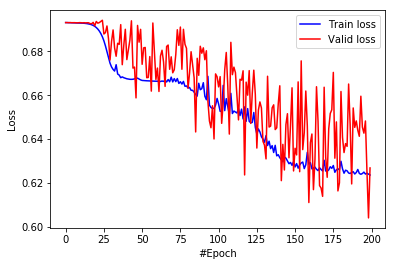

In [4]:
train_loss = autoencoder.log['train_loss']
valid_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.plot(range(len(valid_loss)), valid_loss, color='red', label='Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

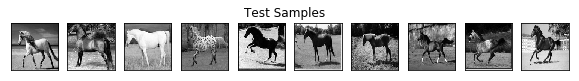

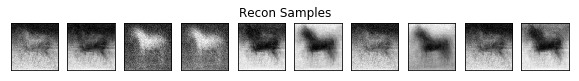

In [5]:
n = 10

orig_imgs = autoencoder.teX[:n].reshape(-1, width, height)
recon_imgs = autoencoder.reconstruct(
  orig_imgs.reshape(-1, width * height)).reshape(-1, width, height)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Recon Samples')

(90,)


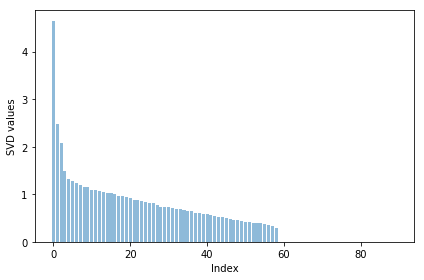

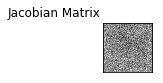

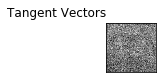

In [6]:
sess = tf.Session()
img = autoencoder.teX[:1]
jaco_matrix = autoencoder.get_jaco_matrix(img)
V = tangent_vecs(jaco_matrix[0])
plot_imgs(jaco_matrix.reshape(-1, width, height), n=1, title='Jacobian Matrix')
plot_imgs(V.reshape(-1, width, height), n=1, title='Tangent Vectors')


In [27]:
import scipy

manifold = V.reshape(-1, width, height)[0]
scipy.misc.imsave('manifold_106062541.png', manifold)

## Exercise 2

In [7]:
#reset tensorflow graph
tf.reset_default_graph()
sess.close()
#reset the system path
sys.path.pop()

'C:\\Users\\Rohan\\.ipython'

In [8]:
import sys
sys.path.append('GAN')
from GAN.utils import *
from GAN.ops import *

import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
from glob import glob
from tensorflow.contrib import learn
import numpy as np
from tqdm import tqdm

In [9]:
class IWGAN(object):
  def __init__(self,
               sess,
               input_height=28,
               input_width=28,
               crop=True,
               batch_size=128,
               output_height=28,
               output_width=28,
               y_dim=None,
               z_dim=100,
               gf_dim=64,
               df_dim=64,
               gfc_dim=1024,
               dfc_dim=1024,
               c_dim=1,
               dataset_name='mnist',
               input_fname_pattern='*.jpg',
               checkpoint_dir='checkpoint',
               samples_dir=None,
               show_samples=False,
               learning_rate=5e-4,
               beta1=0.0,
               beta2=0.9,
               penalty_coeff=10,
               n_critic=5,
               epoch=100):
    """
    Args:
      sess: TensorFlow session
      batch_size: The size of batch. Should be specified before training.
      y_dim: (optional) Dimension of dim for y. [None]
      z_dim: (optional) Dimension of dim for Z. [100]
      gf_dim: (optional) Dimension of gen filters in first conv layer. [64]
      df_dim: (optional) Dimension of discrim filters in first conv layer. [64]
      gfc_dim: (optional) Dimension of gen units for for fully connected layer. [1024]
      dfc_dim: (optional) Dimension of discrim units for fully connected layer. [1024]
      c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
        """
    self.sess = sess

    self.epoch = epoch
    self.batch_size = batch_size
    self.sample_num = 200
    
    #=======================================
    self.n_critic = n_critic
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.penalty_coeff = penalty_coeff
    #=======================================
    
    self.input_height = input_height
    self.input_width = input_width
    self.output_height = output_height
    self.output_width = output_width

    self.y_dim = y_dim
    self.z_dim = z_dim

    self.gf_dim = gf_dim
    self.df_dim = df_dim

    self.gfc_dim = gfc_dim
    self.dfc_dim = dfc_dim

    self.input_fname_pattern = input_fname_pattern
    self.dataset_name = dataset_name
    self.checkpoint_dir = checkpoint_dir
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.samples_dir = samples_dir
    if not os.path.exists(samples_dir) and samples_dir is not None:
      os.makedirs(samples_dir)
    self.show_samples = show_samples

    self.trX, self.teX = self.load_mnist()
    self.ntrain = len(self.trX)
    self.c_dim = 1
    self.grayscale = (self.c_dim == 1)
    self.log = {'d_loss': [], 'g_loss': [], 'gen_samples': []}
    self.build_model()

  def build_model(self):

    # Training critic 5 iterations per generator iteration

    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z) #generated image
    # get the ouput from discriminator for the real and fake data
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(self.D_logits_real)
    self.d_loss_fake = tf.reduce_mean(self.D_logits_fake)
    
    #cost function
    self.g_loss = -tf.reduce_mean(self.D_logits_fake)
    self.d_loss = self.d_loss_fake - self.d_loss_real
    
    #=====================================
    #gradient penalty
    # self.epsilon = tf.random_uniform([], 0.0, 1.0)
    self.epsilon = tf.placeholder(tf.float32, [1], name='epsilon')
    x_hat = self.epsilon*self.inputs + (1-self.epsilon)*self.G
    _, d_hat = self.discriminator(x_hat, reuse=True)
    gradient = tf.gradients(d_hat, x_hat) #tf.gradients(y, x) return dy/dx
    #penalty_term = tf.sqrt( tf.reduce_sum(tf.square(gradient), reduction_indices=[1]) )
    penalty_term = tf.norm( gradient, ord=2, axis=1 )
    gradient_penalty = self.penalty_coeff*(penalty_term-1.0)**2
    self.d_loss += gradient_penalty
    #=======================================
    
    t_vars = tf.trainable_variables()

    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]
    self.saver = tf.train.Saver()

  def train(self):
    
    g_optim = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=self.beta1, beta2=self.beta2).minimize(
        self.g_loss, var_list=self.g_vars)
    d_optim = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=self.beta1, beta2=self.beta2).minimize(
        self.d_loss, var_list=self.d_vars)

    init = tf.global_variables_initializer()
    self.sess.run(init)

    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    self.n_critic += 1
    start_time = time.time()
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        
        epsilon = np.random.uniform(.0, .1, size=(1))
        if counter % self.n_critic:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
                  self.epsilon: epsilon
              })
          
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

  def discriminator(self, image, y=None, reuse=False):
    with tf.variable_scope("discriminator") as scope:
      if reuse:
        scope.reuse_variables()

      x = image

      h0 = lrelu(conv2d(x, self.c_dim, name='d_h0_conv'))
      h1 = lrelu(bn(conv2d(h0, self.df_dim, name='d_h1_conv')))
      h1 = flatten(h1)
      h2 = lrelu(bn(linear(h1, self.dfc_dim, 'd_h2_lin')))
      h3 = linear(h2, 1, 'd_h3_lin')

      return tf.nn.sigmoid(h3), h3

  def generator(self, z, y=None):
    with tf.variable_scope("generator") as scope:
      s_h, s_w = self.output_height, self.output_width #28, 28
      s_h2, s_h4 = int(s_h / 2), int(s_h / 4) #14, 7
      s_w2, s_w4 = int(s_w / 2), int(s_w / 4) #14, 7

      h0 = tf.nn.relu(bn(linear(z, self.gfc_dim, 'g_h0_lin'))) # gfc_dim=1024

      h1 = tf.nn.relu(bn(linear(h0, self.gf_dim * 2 * s_h4 * s_w4, 'g_h1_lin')))#gf_dim(filter dim)=64
      h1 = tf.reshape(h1, [-1, s_h4, s_w4, self.gf_dim * 2])

      h2 = tf.nn.relu(bn(deconv2d(h1, nf=self.gf_dim * 2, name='g_h2')))
      return tf.nn.sigmoid(deconv2d(h2, nf=self.c_dim, name='g_h3'))

  def load_mnist(self):
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images.reshape(-1, 28, 28, 1)  # Returns np.array
    test_data = mnist.test.images.reshape(-1, 28, 28, 1)  # Returns np.array
    return train_data, test_data

  @property
  def model_dir(self):
    return "%s_%s" % (self.dataset_name, self.batch_size)

  def save(self, checkpoint_dir, step):
    model_name = "DCGAN.model"
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.saver.save(
        self.sess, os.path.join(checkpoint_dir, model_name), global_step=step)

  def load(self, checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
      ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
      self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
      counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
      print(" [*] Success to read {}".format(ckpt_name))
      return True, counter
    else:
      print(" [*] Failed to find a checkpoint")
      return False, 0

照著 paper 中的 algorithm，我先加入幾個需要用的變數：penalty coefficient、Adam 要用到的 beta2，並讓 learning rate = 0.9。  
接著，我在每個 batch 進來的時候，隨機 generate 出一個介於 0、1 之間的 epsilon，並在 optimize d_loss 時把 epsilon 餵進去。  
這時，我就能用 epislon 混合 inputs 和 generated images 獲得 x_hat，再丟進 discriminator 後得到 d_hat。  
再來，利用 d_hat 對 x_hat 取 gradients，並根據 penalty 的公式得到 gradient_penalty 的結果，再把他加回 loss function 中。  


In [10]:
checkpoint_dir = 'checkpoint'
samples_dir = 'samples'

tf.reset_default_graph()

sess = tf.Session()
model = IWGAN(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=88,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,
    show_samples=True,
    epoch=100)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


IWGAN中使用到的參數我都是照著 paper 實驗時所使用的。  
我改掉的部分主要是 batch_size，因為我用 128 的話 somehow 會有 shape 的問題，但改成 88 就不會，但原因我始終找不到。

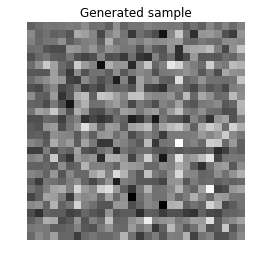

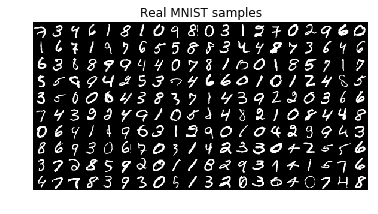

In [11]:
# show_all_variables()
init = tf.global_variables_initializer()
sess.run(init)
sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = model.G.eval(session=model.sess, feed_dict={model.z: sample_z})
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = model.trX[:200]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

Epoch: [ 0] time: 229.21s, d_loss: 4.7102, g_loss: 2.8585
Epoch: [ 1] time: 464.01s, d_loss: 4.4224, g_loss: 0.0388
Epoch: [ 2] time: 693.77s, d_loss: 1.2165, g_loss: 0.5400
Epoch: [ 3] time: 921.57s, d_loss: 4.1119, g_loss: -1.0546
Epoch: [ 4] time: 1149.63s, d_loss: 10.5182, g_loss: -4.1149
Epoch: [ 5] time: 1379.94s, d_loss: 18.7493, g_loss: -9.3337
Epoch: [ 6] time: 1608.38s, d_loss: 24.2332, g_loss: -10.9817
Epoch: [ 7] time: 1837.56s, d_loss: 28.4030, g_loss: -13.1021
Epoch: [ 8] time: 2066.34s, d_loss: 32.9489, g_loss: -15.3246
Epoch: [ 9] time: 2296.29s, d_loss: 36.2244, g_loss: -16.9685


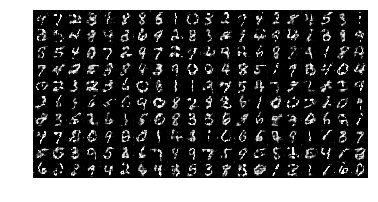

Epoch: [10] time: 2526.78s, d_loss: 40.8585, g_loss: -19.3029
Epoch: [11] time: 2755.34s, d_loss: 44.7141, g_loss: -22.4359
Epoch: [12] time: 2983.35s, d_loss: 45.3947, g_loss: -21.6312
Epoch: [13] time: 3212.58s, d_loss: 48.1390, g_loss: -23.1937
Epoch: [14] time: 3439.86s, d_loss: 49.8338, g_loss: -23.8253
Epoch: [15] time: 3667.62s, d_loss: 52.9055, g_loss: -25.4956
Epoch: [16] time: 3894.04s, d_loss: 54.2794, g_loss: -26.0105
Epoch: [17] time: 4125.53s, d_loss: 57.6108, g_loss: -28.9615
Epoch: [18] time: 4352.75s, d_loss: 58.1134, g_loss: -27.9762
Epoch: [19] time: 4580.34s, d_loss: 58.6549, g_loss: -28.4809


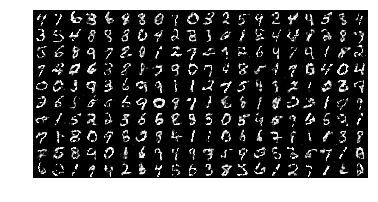

Epoch: [20] time: 4809.54s, d_loss: 59.8869, g_loss: -28.8615
Epoch: [21] time: 5037.10s, d_loss: 61.1242, g_loss: -29.4480
Epoch: [22] time: 5264.24s, d_loss: 62.8307, g_loss: -30.4317
Epoch: [23] time: 5492.34s, d_loss: 64.7550, g_loss: -32.2211
Epoch: [24] time: 5721.26s, d_loss: 66.3651, g_loss: -32.0517
Epoch: [25] time: 5951.11s, d_loss: 68.5754, g_loss: -33.1363
Epoch: [26] time: 6178.69s, d_loss: 69.5409, g_loss: -33.6587
Epoch: [27] time: 6406.74s, d_loss: 73.3530, g_loss: -35.6196
Epoch: [28] time: 6634.15s, d_loss: 75.0366, g_loss: -36.4251
Epoch: [29] time: 6863.31s, d_loss: 78.3684, g_loss: -39.0104


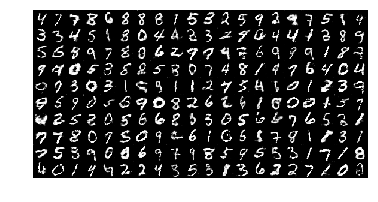

Epoch: [30] time: 7092.61s, d_loss: 78.7899, g_loss: -38.3661
Epoch: [31] time: 7320.00s, d_loss: 79.4047, g_loss: -38.6649
Epoch: [32] time: 7546.79s, d_loss: 80.5587, g_loss: -39.3861
Epoch: [33] time: 7775.17s, d_loss: 81.2668, g_loss: -39.5122
Epoch: [34] time: 8002.05s, d_loss: 82.5626, g_loss: -40.0839
Epoch: [35] time: 8229.66s, d_loss: 84.1697, g_loss: -42.1506
Epoch: [36] time: 8455.32s, d_loss: 83.5678, g_loss: -40.7761
Epoch: [37] time: 8683.37s, d_loss: 85.2996, g_loss: -41.4781
Epoch: [38] time: 8910.29s, d_loss: 86.3118, g_loss: -42.0131
Epoch: [39] time: 9139.86s, d_loss: 85.7731, g_loss: -41.8817


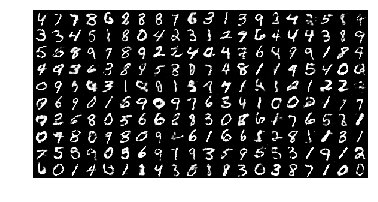

Epoch: [40] time: 9370.83s, d_loss: 85.9470, g_loss: -41.9663
Epoch: [41] time: 9599.98s, d_loss: 87.0974, g_loss: -43.5638
Epoch: [42] time: 9827.97s, d_loss: 87.2939, g_loss: -42.5643
Epoch: [43] time: 10057.13s, d_loss: 88.7501, g_loss: -43.3103
Epoch: [44] time: 10285.30s, d_loss: 89.1078, g_loss: -43.3859
Epoch: [45] time: 10514.59s, d_loss: 88.1275, g_loss: -43.1103
Epoch: [46] time: 10743.24s, d_loss: 88.9609, g_loss: -43.3845
Epoch: [47] time: 10971.87s, d_loss: 89.9486, g_loss: -45.0864
Epoch: [48] time: 11198.96s, d_loss: 90.7441, g_loss: -44.2848
Epoch: [49] time: 11427.15s, d_loss: 89.5990, g_loss: -43.8107


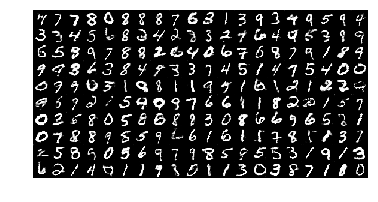

Epoch: [50] time: 11656.43s, d_loss: 91.2013, g_loss: -44.6370
Epoch: [51] time: 11883.95s, d_loss: 91.2549, g_loss: -44.5671
Epoch: [52] time: 12110.70s, d_loss: 90.2645, g_loss: -44.0429
Epoch: [53] time: 12339.03s, d_loss: 92.3864, g_loss: -46.1501
Epoch: [54] time: 12566.73s, d_loss: 91.5387, g_loss: -44.7593
Epoch: [55] time: 12795.61s, d_loss: 91.8416, g_loss: -44.8955
Epoch: [56] time: 13023.98s, d_loss: 93.4826, g_loss: -45.6771
Epoch: [57] time: 13253.26s, d_loss: 93.8441, g_loss: -45.8709
Epoch: [58] time: 13480.37s, d_loss: 94.5934, g_loss: -46.2659
Epoch: [59] time: 13708.84s, d_loss: 95.5828, g_loss: -47.7811


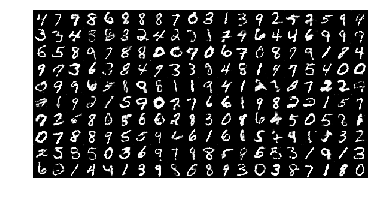

Epoch: [60] time: 13939.83s, d_loss: 94.2318, g_loss: -45.9713
Epoch: [61] time: 14166.85s, d_loss: 95.3126, g_loss: -46.7380
Epoch: [62] time: 14393.27s, d_loss: 96.8358, g_loss: -47.3165
Epoch: [63] time: 14619.98s, d_loss: 96.7411, g_loss: -47.3069
Epoch: [64] time: 14846.29s, d_loss: 95.9546, g_loss: -46.8611
Epoch: [65] time: 15072.96s, d_loss: 97.8892, g_loss: -48.9571
Epoch: [66] time: 15298.71s, d_loss: 96.8034, g_loss: -47.1614
Epoch: [67] time: 15525.05s, d_loss: 97.1699, g_loss: -47.6142
Epoch: [68] time: 15750.84s, d_loss: 97.4437, g_loss: -47.6611
Epoch: [69] time: 15978.90s, d_loss: 98.7715, g_loss: -48.3096


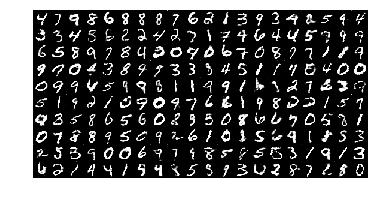

Epoch: [70] time: 16208.29s, d_loss: 99.0142, g_loss: -48.4367
Epoch: [71] time: 16436.93s, d_loss: 100.3801, g_loss: -50.1460
Epoch: [72] time: 16665.03s, d_loss: 98.0053, g_loss: -47.9395
Epoch: [73] time: 16893.12s, d_loss: 98.2580, g_loss: -47.8760
Epoch: [74] time: 17119.35s, d_loss: 100.0360, g_loss: -49.0501
Epoch: [75] time: 17346.57s, d_loss: 100.6560, g_loss: -49.2121
Epoch: [76] time: 17573.30s, d_loss: 99.8323, g_loss: -48.6819
Epoch: [77] time: 17801.35s, d_loss: 101.3855, g_loss: -50.5762
Epoch: [78] time: 18027.94s, d_loss: 100.9279, g_loss: -49.3085
Epoch: [79] time: 18256.40s, d_loss: 102.5144, g_loss: -50.0432


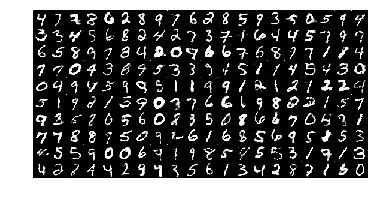

Epoch: [80] time: 18487.10s, d_loss: 100.7993, g_loss: -49.2579
Epoch: [81] time: 18716.17s, d_loss: 101.0043, g_loss: -49.5099
Epoch: [82] time: 18944.30s, d_loss: 101.0294, g_loss: -49.3742
Epoch: [83] time: 19172.57s, d_loss: 102.2795, g_loss: -50.8748
Epoch: [84] time: 19399.02s, d_loss: 101.9695, g_loss: -49.8189
Epoch: [85] time: 19627.02s, d_loss: 101.6581, g_loss: -49.9567
Epoch: [86] time: 19856.32s, d_loss: 102.1186, g_loss: -49.9388
Epoch: [87] time: 20085.05s, d_loss: 103.1401, g_loss: -50.5176
Epoch: [88] time: 20311.90s, d_loss: 102.3973, g_loss: -50.0946
Epoch: [89] time: 20539.14s, d_loss: 104.1035, g_loss: -51.9245


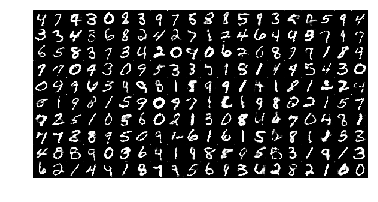

Epoch: [90] time: 20767.79s, d_loss: 103.1382, g_loss: -50.4980
Epoch: [91] time: 20994.74s, d_loss: 103.6731, g_loss: -50.8001
Epoch: [92] time: 21221.38s, d_loss: 103.1119, g_loss: -50.6307
Epoch: [93] time: 21450.00s, d_loss: 104.2758, g_loss: -51.1622
Epoch: [94] time: 21677.38s, d_loss: 104.2037, g_loss: -51.0878
Epoch: [95] time: 21905.50s, d_loss: 105.6002, g_loss: -52.6461
Epoch: [96] time: 22133.54s, d_loss: 104.9602, g_loss: -51.4446
Epoch: [97] time: 22361.29s, d_loss: 104.9118, g_loss: -51.3640
Epoch: [98] time: 22588.20s, d_loss: 104.4830, g_loss: -50.9936
Epoch: [99] time: 22816.23s, d_loss: 105.4036, g_loss: -51.5418


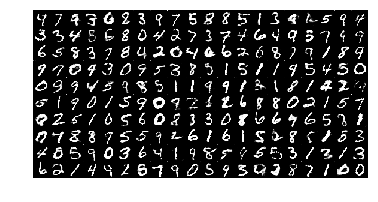

In [12]:
model.train()

In [13]:
import imageio
imageio.plugins.ffmpeg.download()
imgs = np.array(model.log['gen_samples'])
#imageio.plugins.ffmpeg.download()
make_gif(imgs * 255., 'GAN/mnist_106062541.gif', true_image=True, duration=2)


[MoviePy] Building file GAN/iwgan.gif with imageio


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [00:01<00:00, 74.54it/s]


In [15]:
from IPython.display import Image
Image(url='GAN/mnist_106062541.gif')